In [ ]:
!pip install google-colab-shell

from google_colab_shell import getshell

getshell()


**data->dataset.py(multiplicative gamma noise)**
In the provided DatasetNoise class, I can add Multiplicative gamma noise to the input images in the __getitem__ method.

In [ ]:
import torch
import glob
import os
import random
from torchvision import transforms
from PIL import Image
import numpy as np

class DatasetNoise(torch.utils.data.dataset.Dataset):
    def __init__(self, root='/content/denoising/data/FoETrainingSets180/', noise_sigma=50., training=True, crop_size=60, blind_denoising=False, gray_scale=False, max_size=None):
        self.root = root
        self.noise_sigma = noise_sigma
        self.training = training
        self.crop_size = crop_size
        self.blind_denoising = blind_denoising
        self.gray_scale = gray_scale
        self.max_size = max_size

        self._init()

    def _init(self):
        # data paths
        targets = glob.glob(os.path.join(self.root, '*.*'))[:self.max_size]
        self.paths = {'target' : targets}

        # transforms
        t_list = [transforms.ToTensor()]
        self.image_transform = transforms.Compose(t_list)

    def _get_augment_params(self, size):
        random.seed(random.randint(0, 12345))

        # position
        w_size, h_size = size
        x = random.randint(0, max(0, w_size - self.crop_size))
        y = random.randint(0, max(0, h_size - self.crop_size))

        # flip
        flip = random.random() > 0.5
        return {'crop_pos': (x, y), 'flip': flip}

    def _augment(self, image, aug_params):
        x, y = aug_params['crop_pos']
        image = image.crop((x, y, x + self.crop_size, y + self.crop_size))
        if aug_params['flip']:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        return image

    def __getitem__(self, index):
        # target image
        if self.gray_scale:
            target = Image.open(self.paths['target'][index]).convert('L')
        else:
            target = Image.open(self.paths['target'][index]).convert('RGB')

        # transform
        if self.training:
            aug_params = self._get_augment_params(target.size)
            target = self._augment(target, aug_params)
        target = self.image_transform(target) * 255

        # add multiplicative gamma noise
        if self.blind_denoising:
            noise_sigma = random.randint(0, self.noise_sigma)
        else:
            noise_sigma = self.noise_sigma

        shape = target.shape
        gamma_shape = shape  # the shape of the gamma noise should match the image
        gamma_noise = torch.from_numpy(np.random.gamma(shape=1.0, scale=noise_sigma / 255.0, size=gamma_shape)).float()

        input = target * gamma_noise

        return {'input': input, 'target': target, 'path': self.paths['target'][index]}

    def __len__(self):
        return len(self.paths['target'])

# Usage
# dataset = DatasetNoise(root='path_to_your_dataset', noise_sigma=50., training=True, crop_size=60, blind_denoising=False, gray_scale=False, max_size=None)
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
Epoch 2

Epoch 3

Epoch 4

Epoch 5

Epoch 6

Epoch 7

Epoch 8

Epoch 9

Epoch 10
Iteration 101, G: 4887.37382, G_recon: 4887.373817, tnrd_loss: 0.003334,
Evaluation: 16.032

Epoch 11

Epoch 12

Epoch 13

Epoch 14

Epoch 15

Epoch 16

Epoch 17

Epoch 18

Epoch 19
Iteration 201, G: 1611.86506, G_recon: 1611.865063, tnrd_loss: 0.002062,

Epoch 20
Evaluation: 17.420
Best PSNR Score: 17.42

**additive_gamma(data->dataset.py)**

In [ ]:
import torch
import glob
import os
import random
from torchvision import transforms
from PIL import Image
import numpy as np

class DatasetNoise(torch.utils.data.dataset.Dataset):
    def __init__(self, root='/content/denoising/data/FoETrainingSets180/', noise_sigma=50., training=True, crop_size=60, blind_denoising=False, gray_scale=False, max_size=None):
        self.root = root
        self.noise_sigma = noise_sigma
        self.training = training
        self.crop_size = crop_size
        self.blind_denoising = blind_denoising
        self.gray_scale = gray_scale
        self.max_size = max_size

        self._init()

    def _init(self):
        # data paths
        targets = glob.glob(os.path.join(self.root, '*.*'))[:self.max_size]
        self.paths = {'target': targets}

        # transforms
        t_list = [transforms.ToTensor()]
        self.image_transform = transforms.Compose(t_list)

    def _get_augment_params(self, size):
        random.seed(random.randint(0, 12345))

        # position
        w_size, h_size = size
        x = random.randint(0, max(0, w_size - self.crop_size))
        y = random.randint(0, max(0, h_size - self.crop_size))

        # flip
        flip = random.random() > 0.5
        return {'crop_pos': (x, y), 'flip': flip}

    def _augment(self, image, aug_params):
        x, y = aug_params['crop_pos']
        image = image.crop((x, y, x + self.crop_size, y + self.crop_size))
        if aug_params['flip']:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        return image

    def __getitem__(self, index):
        # target image
        if self.gray_scale:
            target = Image.open(self.paths['target'][index]).convert('L')
        else:
            target = Image.open(self.paths['target'][index]).convert('RGB')

        # transform
        if self.training:
            aug_params = self._get_augment_params(target.size)
            target = self._augment(target, aug_params)
        target = self.image_transform(target) * 255

        # add additive gamma noise
        if self.blind_denoising:
            noise_sigma = random.uniform(0, self.noise_sigma)
        else:
            noise_sigma = self.noise_sigma

        shape = target.shape
        additive_gamma_noise = torch.from_numpy(np.random.gamma(shape=1.0, scale=noise_sigma, size=shape)).float()
        input = target + additive_gamma_noise

        return {'input': input, 'target': target, 'path': self.paths['target'][index]}

    def __len__(self):
        return len(self.paths['target'])

# Usage
# dataset = DatasetNoise(root='path_to_your_dataset', noise_sigma=50., training=True, crop_size=60, blind_denoising=False, gray_scale=False, max_size=None)
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


output:
Epoch 2

Epoch 3

Epoch 4

Epoch 5

Epoch 6

Epoch 7

Epoch 8

Epoch 9

Epoch 10
Iteration 101, G: 2574.21986, G_recon: 2574.219865, tnrd_loss: 0.133180,
Evaluation: 15.482

Epoch 11

Epoch 12

Epoch 13

Epoch 14

Epoch 15

Epoch 16

Epoch 17

Epoch 18

Epoch 19
Iteration 201, G: 1775.26349, G_recon: 1775.263491, tnrd_loss: 1.594507,

Epoch 20
Evaluation: 16.354
Best PSNR Score: 16.35

**Gaussion_noise(data->dataset.py)**

In [ ]:
import torch
import glob
import os
import random
from torchvision import transforms
from PIL import Image
import numpy as np

class DatasetNoise(torch.utils.data.dataset.Dataset):
    def __init__(self, root='/content/denoising/data/FoETrainingSets180/', noise_sigma=50., training=True, crop_size=60, blind_denoising=False, gray_scale=False, max_size=None):
        self.root = root
        self.noise_sigma = noise_sigma
        self.training = training
        self.crop_size = crop_size
        self.blind_denoising = blind_denoising
        self.gray_scale = gray_scale
        self.max_size = max_size

        self._init()

    def _init(self):
        # data paths
        targets = glob.glob(os.path.join(self.root, '*.*'))[:self.max_size]
        self.paths = {'target': targets}

        # transforms
        t_list = [transforms.ToTensor()]
        self.image_transform = transforms.Compose(t_list)

    def _get_augment_params(self, size):
        random.seed(random.randint(0, 12345))

        # position
        w_size, h_size = size
        x = random.randint(0, max(0, w_size - self.crop_size))
        y = random.randint(0, max(0, h_size - self.crop_size))

        # flip
        flip = random.random() > 0.5
        return {'crop_pos': (x, y), 'flip': flip}

    def _augment(self, image, aug_params):
        x, y = aug_params['crop_pos']
        image = image.crop((x, y, x + self.crop_size, y + self.crop_size))
        if aug_params['flip']:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        return image

    def __getitem__(self, index):
        # target image
        if self.gray_scale:
            target = Image.open(self.paths['target'][index]).convert('L')
        else:
            target = Image.open(self.paths['target'][index]).convert('RGB')

        # transform
        if self.training:
            aug_params = self._get_augment_params(target.size)
            target = self._augment(target, aug_params)
        target = self.image_transform(target) * 255

        # add Gaussian noise
        if self.blind_denoising:
            noise_sigma = random.uniform(0, self.noise_sigma)
        else:
            noise_sigma = self.noise_sigma

        gaussian_noise = noise_sigma * torch.randn_like(target)
        input = target + gaussian_noise

        return {'input': input, 'target': target, 'path': self.paths['target'][index]}

    def __len__(self):
        return len(self.paths['target'])

# Usage
# dataset = DatasetNoise(root='path_to_your_dataset', noise_sigma=50., training=True, crop_size=60, blind_denoising=False, gray_scale=False, max_size=None)
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


output:
Epoch 2

Epoch 3

Epoch 4

Epoch 5

Epoch 6

Epoch 7

Epoch 8

Epoch 9

Epoch 10
Iteration 101, G: 1986.47201, G_recon: 1986.472006, tnrd_loss: 7.114801,
Evaluation: 16.220

Epoch 11

Epoch 12

Epoch 13

Epoch 14

Epoch 15

Epoch 16

Epoch 17

Epoch 18

Epoch 19
Iteration 201, G: 1109.34377, G_recon: 1109.343768, tnrd_loss: 883.907410,

Epoch 20
Evaluation: 21.615
Best PSNR Score: 21.61

**Add Multiplicative_Gamma_Noise:datasets.py(In the provided DatasetNoise class, you can add Multiplicative_Gamma noise to the input images in the __getitem__ method)                               activations.py(This modification allows you to incorporate Multiplicative_Gamma noise into the input before applying the RBF transformation within your neural network model.)**

data ->> datasets.py

In [ ]:
import torch
import glob
import os
import random
from torchvision import transforms
from PIL import Image
import numpy as np

class DatasetNoise(torch.utils.data.dataset.Dataset):
    def __init__(self, root='/content/denoising/data/FoETrainingSets180/', noise_sigma=50., training=True, crop_size=60, blind_denoising=False, gray_scale=False, max_size=None):
        self.root = root
        self.noise_sigma = noise_sigma
        self.training = training
        self.crop_size = crop_size
        self.blind_denoising = blind_denoising
        self.gray_scale = gray_scale
        self.max_size = max_size

        self._init()

    def _init(self):
        # data paths
        targets = glob.glob(os.path.join(self.root, '*.*'))[:self.max_size]
        self.paths = {'target' : targets}

        # transforms
        t_list = [transforms.ToTensor()]
        self.image_transform = transforms.Compose(t_list)

    def _get_augment_params(self, size):
        random.seed(random.randint(0, 12345))

        # position
        w_size, h_size = size
        x = random.randint(0, max(0, w_size - self.crop_size))
        y = random.randint(0, max(0, h_size - self.crop_size))

        # flip
        flip = random.random() > 0.5
        return {'crop_pos': (x, y), 'flip': flip}

    def _augment(self, image, aug_params):
        x, y = aug_params['crop_pos']
        image = image.crop((x, y, x + self.crop_size, y + self.crop_size))
        if aug_params['flip']:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        return image

    def __getitem__(self, index):
        # target image
        if self.gray_scale:
            target = Image.open(self.paths['target'][index]).convert('L')
        else:
            target = Image.open(self.paths['target'][index]).convert('RGB')

        # transform
        if self.training:
            aug_params = self._get_augment_params(target.size)
            target = self._augment(target, aug_params)
        target = self.image_transform(target) * 255

        # add multiplicative gamma noise
        if self.blind_denoising:
            noise_sigma = random.randint(0, self.noise_sigma)
        else:
            noise_sigma = self.noise_sigma

        shape = target.shape
        gamma_shape = shape  # the shape of the gamma noise should match the image
        gamma_noise = torch.from_numpy(np.random.gamma(shape=1.0, scale=noise_sigma / 255.0, size=gamma_shape)).float()

        input = target * gamma_noise

        return {'input': input, 'target': target, 'path': self.paths['target'][index]}

    def __len__(self):
        return len(self.paths['target'])

# Usage
# dataset = DatasetNoise(root='path_to_your_dataset', noise_sigma=50., training=True, crop_size=60, blind_denoising=False, gray_scale=False, max_size=None)
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


model -> activations.py

In [ ]:
import torch.nn as nn
import torch
import numpy as np
import math
import torch.nn.functional as F


# RBF Layer

# RBF Layer
class RBF(nn.Module):
    """
    Transforms incoming data using a given radial basis function:
    u_{i} = rbf(||x - c_{i}|| / s_{i})
    Arguments:
        in_features: size of each input sample
        out_features: size of each output sample
    Shape:
        - Input: (N, in_features) where N is an arbitrary batch size
        - Output: (N, out_features) where N is an arbitrary batch size
    Attributes:
        centers: the learnable centers of shape (out_features, in_features).
            The values are initialised from a standard normal distribution.
            Normalising inputs to have mean 0 and standard deviation 1 is
            recommended.

        sigmas: the learnable scaling factors of shape (out_features).
            The values are initialised as ones.

        basis_func: the radial basis function used to transform the scaled
            distances.
    """

    def __init__(self, num_func, num_filters, basis_func):
        super(RBF, self).__init__()
        self.num_func = num_func
        self.register_buffer('centers', torch.tensor(np.linspace(-310, 310, num_func)).float())
        self.num_filters = num_filters
        self.weight = nn.Parameter(torch.Tensor(num_func, 1, num_filters))
        self.gamma = 10
        self.basis_func = basis_func
        self.int_basis_func = erf_func

    def forward(self, input, shape_param=2.0, scale_param=1.0):
        # Generate and apply multiplicative gamma noise
        noise = torch.tensor(np.random.gamma(shape_param, scale_param, input.shape)).float().to(input.device)
        input = input * noise

        size = [self.num_func] + list(input.shape)
        x = input.expand(size)
        c = self.centers.view(-1, 1, 1, 1, 1)
        weight = self.weight.view(-1, 1, self.num_filters, 1, 1)

        if self.basis_func == gaussian:
            distances = (x - c).div(self.gamma)
            return self.basis_func(distances).mul(weight).sum(0), self.int_basis_func(distances, self.gamma).mul(weight).sum(0)
        else:
            distances = (x - c).abs()
            return self.basis_func(distances, self.gamma).mul(weight).sum(0), 0

# RBFs
def gaussian(alpha):
    phi = torch.exp(-0.5 * alpha.pow(2))
    return phi

def erf_func(alpha, gamma):
    phi = gamma * math.sqrt(math.pi / 2) * torch.erf(alpha.div(math.sqrt(2)))
    return phi

def linear(alpha):
    phi = alpha
    return phi

def quadratic(alpha):
    phi = alpha.pow(2)
    return phi

def inverse_quadratic(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2))
    return phi

def multiquadric(alpha):
    phi = (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def inverse_multiquadric(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def spline(alpha):
    phi = (alpha.pow(2) * torch.log(alpha + torch.ones_like(alpha)))
    return phi

def poisson_one(alpha):
    phi = (alpha - torch.ones_like(alpha)) * torch.exp(-alpha)
    return phi

def poisson_two(alpha):
    phi = ((alpha - 2 * torch.ones_like(alpha)) / 2 * torch.ones_like(alpha)) * alpha * torch.exp(-alpha)
    return phi

def matern32(alpha):
    phi = (torch.ones_like(alpha) + 3**0.5 * alpha) * torch.exp(-3**0.5 * alpha)
    return phi

def matern52(alpha):
    phi = (torch.ones_like(alpha) + 5**0.5 * alpha + (5 / 3) * alpha.pow(2)) * torch.exp(-5**0.5 * alpha)
    return phi

def triangular(alpha, gamma):
    out = 1 - alpha.div(gamma)
    out[alpha > gamma] = 0
    return out

def basis_func_dict():
    """
    A helper function that returns a dictionary containing each RBF
    """
    bases = {
        'gaussian': gaussian,
        'linear': linear,
        'quadratic': quadratic,
        'inverse quadratic': inverse_quadratic,
        'multiquadric': multiquadric,
        'inverse multiquadric': inverse_multiquadric,
        'spline': spline,
        'poisson one': poisson_one,
        'poisson two': poisson_two,
        'matern32': matern32,
        'matern52': matern52
    }
    return bases



output:
Epoch 2

Epoch 3

Epoch 4

Epoch 5

Epoch 6

Epoch 7

Epoch 8

Epoch 9

Epoch 10
Iteration 101, G: 4880.41020, G_recon: 4880.410203, tnrd_loss: 0.000450,
Evaluation: 15.340

Epoch 11

Epoch 12

Epoch 13

Epoch 14

Epoch 15

Epoch 16

Epoch 17

Epoch 18

Epoch 19
Iteration 201, G: 1990.89918, G_recon: 1990.899175, tnrd_loss: 0.000065,

Epoch 20
Evaluation: 16.154
Best PSNR Score: 16.15

dataset.py



In [ ]:
import torch
import glob
import os
import random
from torchvision import transforms
from PIL import Image
import numpy as np

class DatasetNoise(torch.utils.data.dataset.Dataset):
    def __init__(self, root='/content/denoising/data/FoETrainingSets180/', noise_sigma=50., training=True, crop_size=60, blind_denoising=False, gray_scale=False, max_size=None):
        self.root = root
        self.noise_sigma = noise_sigma
        self.training = training
        self.crop_size = crop_size
        self.blind_denoising = blind_denoising
        self.gray_scale = gray_scale
        self.max_size = max_size

        self._init()

    def _init(self):
        # data paths
        targets = glob.glob(os.path.join(self.root, '*.*'))[:self.max_size]
        self.paths = {'target' : targets}

        # transforms
        t_list = [transforms.ToTensor()]
        self.image_transform = transforms.Compose(t_list)

    def _get_augment_params(self, size):
        random.seed(random.randint(0, 12345))

        # position
        w_size, h_size = size
        x = random.randint(0, max(0, w_size - self.crop_size))
        y = random.randint(0, max(0, h_size - self.crop_size))

        # flip
        flip = random.random() > 0.5
        return {'crop_pos': (x, y), 'flip': flip}

    def _augment(self, image, aug_params):
        x, y = aug_params['crop_pos']
        image = image.crop((x, y, x + self.crop_size, y + self.crop_size))
        if aug_params['flip']:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        return image

    def __getitem__(self, index):
        # target image
        if self.gray_scale:
            target = Image.open(self.paths['target'][index]).convert('L')
        else:
            target = Image.open(self.paths['target'][index]).convert('RGB')

        # transform
        if self.training:
            aug_params = self._get_augment_params(target.size)
            target = self._augment(target, aug_params)
        target = self.image_transform(target) * 255

        # add multiplicative gamma noise
        if self.blind_denoising:
            noise_sigma = random.randint(0, self.noise_sigma)
        else:
            noise_sigma = self.noise_sigma

        L = 1
        a = L
        b = 1 / L
        #shape = target.shape
        gamma_shape = target.shape # the shape of the gamma noise should match the image
        gamma_noise = torch.from_numpy(np.random.gamma(shape=a, scale=b, size=gamma_shape)).float()

        input = target * gamma_noise

        return {'input': input, 'target': target, 'path': self.paths['target'][index]}

    def __len__(self):
        return len(self.paths['target'])

# Usage
# dataset = DatasetNoise(root='path_to_your_dataset', noise_sigma=50., training=True, crop_size=60, blind_denoising=False, gray_scale=False, max_size=None)
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


add multiplicative gamma
(dataset.py)->data

In [ ]:
import torch
import glob
import os
import random
from torchvision import transforms
from PIL import Image
import numpy as np

class DatasetNoise(torch.utils.data.dataset.Dataset):
    def __init__(self, root='/content/denoising/data/FoETrainingSets180/', noise_sigma=50., training=True, crop_size=60, blind_denoising=False, gray_scale=False, max_size=None):
        self.root = root
        self.noise_sigma = noise_sigma
        self.training = training
        self.crop_size = crop_size
        self.blind_denoising = blind_denoising
        self.gray_scale = gray_scale
        self.max_size = max_size

        self._init()

    def _init(self):
        # data paths
        targets = glob.glob(os.path.join(self.root, '*.*'))[:self.max_size]
        self.paths = {'target' : targets}

        # transforms
        t_list = [transforms.ToTensor()]
        self.image_transform = transforms.Compose(t_list)

    def _get_augment_params(self, size):
        random.seed(random.randint(0, 12345))

        # position
        w_size, h_size = size
        x = random.randint(0, max(0, w_size - self.crop_size))
        y = random.randint(0, max(0, h_size - self.crop_size))

        # flip
        flip = random.random() > 0.5
        return {'crop_pos': (x, y), 'flip': flip}

    def _augment(self, image, aug_params):
        x, y = aug_params['crop_pos']
        image = image.crop((x, y, x + self.crop_size, y + self.crop_size))
        if aug_params['flip']:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        return image

    def __getitem__(self, index):
        # target image
        if self.gray_scale:
            target = Image.open(self.paths['target'][index]).convert('L')
        else:
            target = Image.open(self.paths['target'][index]).convert('RGB')

        # transform
        if self.training:
            aug_params = self._get_augment_params(target.size)
            target = self._augment(target, aug_params)
        target = self.image_transform(target) * 255

        # add multiplicative gamma noise
        #if self.blind_denoising:
            #noise_sigma = random.randint(0, self.noise_sigma)
        #else:
            #noise_sigma = self.noise_sigma
        L = 2
        a = L
        b = 1 / L
        #shape = target.shape
        gamma_shape = target.shape # the shape of the gamma noise should match the image
        gamma_noise = torch.from_numpy(np.random.gamma(shape=a, scale=b, size=gamma_shape)).float()
        #shape = target.shape
        #gamma_shape = shape  # the shape of the gamma noise should match the image
        #gamma_noise = torch.from_numpy(np.random.gamma(shape=1.0, scale=noise_sigma / 255.0, size=gamma_shape)).float()

        input = target * gamma_noise

        return {'input': input, 'target': target, 'path': self.paths['target'][index]}

    def __len__(self):
        return len(self.paths['target'])

# Usage
# dataset = DatasetNoise(root='path_to_your_dataset', noise_sigma=50., training=True, crop_size=60, blind_denoising=False, gray_scale=False, max_size=None)
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


main.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.spectral_norm import spectral_norm as SpectralNorm
from .modules.activations import *
import torchvision
from .modules.idct2_weight import gen_dct2
import numpy as np
import math

_NRBF=63
_DCT=False
_TIE = False
_BETA = False
_C1x1 = False
__all__ = ['g_tnrd','d_tnrd','TNRDlayer']

def initialize_weights(net, scale=1.):
    if not isinstance(net, list):
        net = [net]
    for layer in net:
        for m in layer.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, TNRDConv2d) or isinstance(m, TNRDlayer):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale  # for residual block
                if not _TIE and isinstance(m, TNRDlayer):
                    nn.init.kaiming_normal_(m.weight2, a=0, mode='fan_in')
                    m.weight.data *= scale  # for residual block
                if m.bias is not None and not isinstance(m, TNRDlayer):
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias.data, 0.0)


def init_model_param(model,num_reb_kernels=63,filter_size=5,stage=8,init_weight_dct=_DCT):
    w0 = np.load('w0_orig.npy')
    w0 = np.histogram(np.random.randn(1000)*0.02,num_reb_kernels-1)[1] if _NRBF != 63 else w0
    #
    means=np.linspace(-310,310,num_reb_kernels)
    precision=0.01
    NumW = num_reb_kernels
    step = 0.2
    delta = 10

    D = np.arange(-delta+means[0],means[-1]+delta,step)
    D_mu = D.reshape(1,-1).repeat(NumW,0) - means.reshape(-1,1).repeat(D.size,1)
    offsetD = D[1]
    nD = D.size
    G = np.exp(-0.5*precision*D_mu**2)
    filtN =  filter_size**2 - 1
    m = filter_size**2 - 1

    ww = np.array(w0).reshape(-1,1).repeat(filtN,1)
    cof_beta = np.eye(m,m)
    #x0 = zeros(length(cof_beta(:)) + 1 + filtN*mfs.NumW, stage);
    theta = [10, 5]+ np.ones(stage-2).tolist()
    pp = [math.log(1.0)]+ (math.log(0.1)*np.ones(stage-1)).tolist()
    # beta = [log(1) log(0.1)*ones(1,stage-1)];
    i=-1
    #import pdb; pdb.set_trace()
    for module in model.modules():
        if isinstance(module,TNRDlayer):
            i+=1
            init_layer_params(module,cof_beta, pp[i], ww*theta[i],init_weight_dct)

def init_layer_params(m,beta,p,wt,init_weight_dct):

    with torch.no_grad():
        if init_weight_dct:
            m.weight.copy_(torch.Tensor(beta))
        else:
            n = m.kernel_size**2 * m.in_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            if not _TIE and isinstance(m, TNRDlayer):
                weight_rot180 = torch.rot90(torch.rot90(m.weight.data.detach(), 1, [2, 3]),1,[2,3])
                m.weight2.data.copy_(weight_rot180)
                #m.weight2.data.normal_(0, math.sqrt(2. / n))
            #initialize_weights(m,0.02)
        m.alpha.copy_(torch.Tensor([p]))
        if m.act.weight.shape[-1]==24:
            m.act.weight.copy_(torch.Tensor(wt).unsqueeze(1))


class TNRDConv2d(nn.Conv2d):
    """docstring for TNRDConv2d."""

    def __init__(self, in_channels, out_channels, kernel_size=5,
                 stride=1, padding=2, dilation=1, groups=1, bias=True):
        super(TNRDConv2d, self).__init__(in_channels, out_channels, kernel_size,
                                      stride, padding, dilation, groups, bias)

        self.act = RBF(63,self.in_channels,triangular)
        self.alpha=nn.Parameter(torch.Tensor([0.9]))
        self.beta=nn.Parameter(torch.Tensor([1]))
        initialize_weights_dct([self], 0.02)
        self.pad_input=torchvision.transforms.Pad(5,padding_mode='edge')
        #initialize_weights([self.act], 0.00002)
        self.counter = 0
    def forward(self,input):
        self.counter+=1
        u,f=input
        up = self.pad_input(u)
        ur = up.repeat(1,self.in_channels,1,1)
        #
        output1 = F.conv2d(ur, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        output,_ = self.act(output1)
        weight_rot180 = torch.rot90(torch.rot90(self.weight, 1, [2, 3]),1,[2,3])
        #
        output = F.conv2d(output, weight_rot180, self.bias, self.stride, self.padding, self.dilation, self.groups)
        output = F.pad(output,(-5,-5,-5,-5))
        #import pdb; pdb.set_trace()
        if self.counter%100==0:
            print(self.alpha,self.beta.max(),self.beta.min(),self.act.weight.max(),self.act.weight.min(),output.sum(1,keepdim=True).max())
        output = u-self.beta*output.sum(1,keepdim=True)-self.alpha*(u-f)
        return output,f

class TNRDlayer(nn.Module):
    """docstring for TNRDConv2d."""

    def __init__(self, in_channels, out_channels, kernel_size=5,
                 stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(TNRDlayer, self).__init__()
        self.in_channels = in_channels
        self.stride=stride
        self.groups=groups
        self.bias=bias
        self.padding=padding
        self.stride=stride
        self.dilation=dilation
        self.kernel_size=kernel_size
        self.act = RBF(_NRBF,self.in_channels,gaussian)
        self.alpha=nn.Parameter(torch.Tensor([0.9]))
        self.beta=nn.Parameter(torch.zeros([1,self.in_channels,1,1]))
        if _DCT:
            self.weight = nn.Parameter(torch.zeros([in_channels,in_channels]))
        else:
            self.weight = nn.Parameter(torch.zeros([in_channels,1,kernel_size,kernel_size]))
            if not _TIE:
                self.weight2 = nn.Parameter(torch.zeros([in_channels,1,kernel_size,kernel_size]))
        if _C1x1:
            self.weight_1x1=nn.Parameter(torch.zeros([in_channels,in_channels,1,1]))

        #initialize_weights_dct([self], 0.02)
        self.register_buffer('dct_filters',torch.tensor(gen_dct2(kernel_size)[1:,:]).float())

        self.pad_input=torchvision.transforms.Pad(12,padding_mode='symmetric')
        #initialize_weights([self.act], 0.00002)
        self.counter = 0

    def forward(self, input):
        self.counter += 1
        u, f = input
        u_prev = u

        # Ensure to detach tensors before converting to numpy
        u_cpu = u.detach().cpu().numpy()
        u_t = np.zeros_like(u_cpu)

        for it in range(1):
            up = self.pad_input(u)
            ur = up.repeat(1, self.in_channels, 1, 1)

            if _DCT:
                K = self.weight.matmul(self.dct_filters)
                K = K.div(torch.norm(K, dim=1, keepdim=True) + 2.2e-16).view(self.kernel_size**2 - 1, 1, self.kernel_size, self.kernel_size)
            else:
                K = self.weight

            output1 = F.conv2d(ur, K, None, self.stride, self.padding, self.dilation, self.groups)
            output, _ = self.act(output1)
            weight_rot180 = torch.rot90(torch.rot90(K, 1, [2, 3]), 1, [2, 3]) if _TIE else self.weight2

            if _C1x1:
                output = F.conv2d(output, self.weight_1x1, None, self.stride, self.padding, self.dilation)
            output = F.conv2d(output, weight_rot180, None, self.stride, self.padding, self.dilation, self.groups)
            output = F.pad(output, (-8, -8, -8, -8))

            if self.counter % 500 == 0:
                print(self.alpha, self.beta.max(), self.beta.min(), self.act.weight.max(), self.act.weight.min(), output.sum(1, keepdim=True).max())
            beta = self.beta if _BETA else 1
            u_next = ((self.alpha.exp()+2)/(1+self.alpha.exp())) * u - (1/(1+self.alpha.exp())) * u_prev + output.mul(beta).sum(1, keepdim=True) - self.alpha.exp() * ((u - f)/(u**2+1))

            u_prev = u
            u = u_next

        return u, f

class GenBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, kernel_size=5, bias=True):
        super(GenBlock, self).__init__()
        self.conv = TNRDConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=(kernel_size // 2), bias=bias)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU(inplace=True)

        initialize_weights([self.conv, self.bn], 0.02)

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        return x

class DisBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, bias=True, normalization=False):
        super(DisBlock, self).__init__()
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=bias)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_channels, affine=True)
        self.bn2 = nn.BatchNorm2d(out_channels, affine=True)

        initialize_weights([self.conv1, self.conv2], 0.1)

        if normalization:
            self.conv1 = SpectralNorm(self.conv1)
            self.conv2 = SpectralNorm(self.conv2)

    def forward(self, x):
        x = self.lrelu(self.bn1(self.conv1(x)))
        x = self.lrelu(self.bn2(self.conv2(x)))
        return x

class Generatorv1(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(Generatorv1, self).__init__()
        filter_size=5
        # image to features
        in_channels=filter_size**2

        #self.crop_output=torchvision.transforms.CenterCrop(50)
        self.image_to_features = TNRDConv2d(in_channels=in_channels, out_channels=in_channels,kernel_size=filter_size, groups=in_channels)
        # features
        blocks = []
        for _ in range(gen_blocks):
            blocks.append(TNRDConv2d(in_channels=in_channels, out_channels=in_channels,kernel_size=filter_size, bias=False,groups=in_channels))
        self.features = nn.Sequential(*blocks)

        # features to image
        self.features_to_image = TNRDConv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=filter_size,groups=in_channels)
        initialize_weights([self.features_to_image], 0.02)
        self.counter=0
    def forward(self, x):
        self.counter+=1
        x = self.image_to_features([x,x])
        x = self.features(x)
        x = self.features_to_image(x)
        return x[0]

class Generator(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(Generator, self).__init__()
        filter_size=5
        # image to features
        in_channels=(filter_size**2-1)

        #self.crop_output=torchvision.transforms.CenterCrop(50)
        self.image_to_features = TNRDlayer(in_channels=in_channels, out_channels=in_channels,groups=in_channels)
        # features
        blocks = []
        for _ in range(gen_blocks):
            blocks.append(TNRDlayer(in_channels=in_channels, out_channels=in_channels, bias=False,groups=in_channels))
        self.features = nn.Sequential(*blocks)

        #self.features = []
        #for _ in range(gen_blocks):
        #    self.features.append(TNRDlayer(in_channels=in_channels, out_channels=in_channels, bias=False,groups=in_channels))

        # features to image
        self.features_to_image = TNRDlayer(in_channels=in_channels, out_channels=in_channels, kernel_size=5,groups=in_channels)
        #initialize_weights([self.features_to_image], 0.02)
        self.counter=0
        init_model_param(self,num_reb_kernels=_NRBF,filter_size=5,stage=gen_blocks+2)

    def forward(self, x):

        self.counter+=1
        x = self.image_to_features([x,x])
        x = self.features(x)
        x = self.features_to_image(x)
        return x[0]

class Discriminator(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(Discriminator, self).__init__()

        # image to features
        self.image_to_features = DisBlock(in_channels=in_channels, out_channels=num_features, bias=True, normalization=False)

        # features
        blocks = []
        for i in range(0, dis_blocks - 1):
            blocks.append(DisBlock(in_channels=num_features * min(pow(2, i), 8), out_channels=num_features * min(pow(2, i + 1), 8), bias=False, normalization=False))
        self.features = nn.Sequential(*blocks)

        # classifier
        self.classifier = nn.Conv2d(in_channels=num_features * min(pow(2, dis_blocks - 1), 8), out_channels=1, kernel_size=4, padding=0)

    def forward(self, x):
        x = self.image_to_features(x)
        x = self.features(x)
        x = self.classifier(x)
        x = x.flatten(start_dim=1).mean(dim=-1)
        return x

class SNDiscriminator(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(SNDiscriminator, self).__init__()

        # image to features
        self.image_to_features = DisBlock(in_channels=in_channels, out_channels=num_features, bias=True, normalization=True)

        # features
        blocks = []
        for i in range(0, dis_blocks - 1):
            blocks.append(DisBlock(in_channels=num_features * min(pow(2, i), 8), out_channels=num_features * min(pow(2, i + 1), 8), bias=False, normalization=True))
        self.features = nn.Sequential(*blocks)

        # classifier
        self.classifier = SpectralNorm(nn.Conv2d(in_channels=num_features * min(pow(2, dis_blocks - 1), 8), out_channels=1, kernel_size=4, padding=0))

    def forward(self, x):
        x = self.image_to_features(x)
        x = self.features(x)
        x = self.classifier(x)
        x = x.flatten(start_dim=1).mean(dim=-1)
        return x

def g_tnrd(**config):
    config.setdefault('in_channels', 3)
    config.setdefault('num_features', 64)
    config.setdefault('gen_blocks', 3)
    config.setdefault('dis_blocks', 5)

    return Generator(**config)

def d_tnrd(**config):
    config.setdefault('in_channels', 3)
    config.setdefault('num_features', 64)
    config.setdefault('gen_blocks', 8)
    config.setdefault('dis_blocks', 5)

    return Discriminator(**config)

output:
Epoch 2

Epoch 3

Epoch 4

Epoch 5

Epoch 6

Epoch 7

Epoch 8

Epoch 9

Epoch 10
Iteration 101, G: 3948.60185, G_recon: 3948.601853, tnrd_loss: 0.442866,
Evaluation: 12.871

Epoch 11

Epoch 12

Epoch 13

Epoch 14

Epoch 15

Epoch 16

Epoch 17

Epoch 18

Epoch 19
Iteration 201, G: 3182.31451, G_recon: 3182.314515, tnrd_loss: 26.381798,

Epoch 20
Evaluation: 14.530
Best PSNR Score: 14.53



"here we only modified this two file of TNRD 'main.py' and 'dataset.py'  "

**if we do not change 'main.py' only change 'dataset.py'(only add multiplicative gamma noise )**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.spectral_norm import spectral_norm as SpectralNorm
from .modules.activations import *
import torchvision
from .modules.idct2_weight import gen_dct2
import numpy as np
import math

_NRBF=63
_DCT=False
_TIE = False
_BETA = False
_C1x1 = False
__all__ = ['g_tnrd','d_tnrd','TNRDlayer']

def initialize_weights(net, scale=1.):
    if not isinstance(net, list):
        net = [net]
    for layer in net:
        for m in layer.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, TNRDConv2d) or isinstance(m, TNRDlayer):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale  # for residual block
                if not _TIE and isinstance(m, TNRDlayer):
                    nn.init.kaiming_normal_(m.weight2, a=0, mode='fan_in')
                    m.weight.data *= scale  # for residual block
                if m.bias is not None and not isinstance(m, TNRDlayer):
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias.data, 0.0)


def init_model_param(model,num_reb_kernels=63,filter_size=5,stage=8,init_weight_dct=_DCT):
    w0 = np.load('w0_orig.npy')
    w0 = np.histogram(np.random.randn(1000)*0.02,num_reb_kernels-1)[1] if _NRBF != 63 else w0
    #
    means=np.linspace(-310,310,num_reb_kernels)
    precision=0.01
    NumW = num_reb_kernels
    step = 0.2
    delta = 10

    D = np.arange(-delta+means[0],means[-1]+delta,step)
    D_mu = D.reshape(1,-1).repeat(NumW,0) - means.reshape(-1,1).repeat(D.size,1)
    offsetD = D[1]
    nD = D.size
    G = np.exp(-0.5*precision*D_mu**2)
    filtN =  filter_size**2 - 1
    m = filter_size**2 - 1

    ww = np.array(w0).reshape(-1,1).repeat(filtN,1)
    cof_beta = np.eye(m,m)
    #x0 = zeros(length(cof_beta(:)) + 1 + filtN*mfs.NumW, stage);
    theta = [10, 5]+ np.ones(stage-2).tolist()
    pp = [math.log(1.0)]+ (math.log(0.1)*np.ones(stage-1)).tolist()
    # beta = [log(1) log(0.1)*ones(1,stage-1)];
    i=-1
    #import pdb; pdb.set_trace()
    for module in model.modules():
        if isinstance(module,TNRDlayer):
            i+=1
            init_layer_params(module,cof_beta, pp[i], ww*theta[i],init_weight_dct)

def init_layer_params(m,beta,p,wt,init_weight_dct):

    with torch.no_grad():
        if init_weight_dct:
            m.weight.copy_(torch.Tensor(beta))
        else:
            n = m.kernel_size**2 * m.in_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            if not _TIE and isinstance(m, TNRDlayer):
                weight_rot180 = torch.rot90(torch.rot90(m.weight.data.detach(), 1, [2, 3]),1,[2,3])
                m.weight2.data.copy_(weight_rot180)
                #m.weight2.data.normal_(0, math.sqrt(2. / n))
            #initialize_weights(m,0.02)
        m.alpha.copy_(torch.Tensor([p]))
        if m.act.weight.shape[-1]==24:
            m.act.weight.copy_(torch.Tensor(wt).unsqueeze(1))


class TNRDConv2d(nn.Conv2d):
    """docstring for TNRDConv2d."""

    def __init__(self, in_channels, out_channels, kernel_size=5,
                 stride=1, padding=2, dilation=1, groups=1, bias=True):
        super(TNRDConv2d, self).__init__(in_channels, out_channels, kernel_size,
                                      stride, padding, dilation, groups, bias)

        self.act = RBF(63,self.in_channels,triangular)
        self.alpha=nn.Parameter(torch.Tensor([0.9]))
        self.beta=nn.Parameter(torch.Tensor([1]))
        initialize_weights_dct([self], 0.02)
        self.pad_input=torchvision.transforms.Pad(5,padding_mode='edge')
        #initialize_weights([self.act], 0.00002)
        self.counter = 0
    def forward(self,input):
        self.counter+=1
        u,f=input
        up = self.pad_input(u)
        ur = up.repeat(1,self.in_channels,1,1)
        #
        output1 = F.conv2d(ur, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        output,_ = self.act(output1)
        weight_rot180 = torch.rot90(torch.rot90(self.weight, 1, [2, 3]),1,[2,3])
        #
        output = F.conv2d(output, weight_rot180, self.bias, self.stride, self.padding, self.dilation, self.groups)
        output = F.pad(output,(-5,-5,-5,-5))
        #import pdb; pdb.set_trace()
        if self.counter%100==0:
            print(self.alpha,self.beta.max(),self.beta.min(),self.act.weight.max(),self.act.weight.min(),output.sum(1,keepdim=True).max())
        output = u-self.beta*output.sum(1,keepdim=True)-self.alpha*(u-f)
        return output,f

class TNRDlayer(nn.Module):
    """docstring for TNRDConv2d."""

    def __init__(self, in_channels, out_channels, kernel_size=5,
                 stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(TNRDlayer, self).__init__()
        self.in_channels = in_channels
        self.stride=stride
        self.groups=groups
        self.bias=bias
        self.padding=padding
        self.stride=stride
        self.dilation=dilation
        self.kernel_size=kernel_size
        self.act = RBF(_NRBF,self.in_channels,gaussian)
        self.alpha=nn.Parameter(torch.Tensor([0.9]))
        self.beta=nn.Parameter(torch.zeros([1,self.in_channels,1,1]))
        if _DCT:
            self.weight = nn.Parameter(torch.zeros([in_channels,in_channels]))
        else:
            self.weight = nn.Parameter(torch.zeros([in_channels,1,kernel_size,kernel_size]))
            if not _TIE:
                self.weight2 = nn.Parameter(torch.zeros([in_channels,1,kernel_size,kernel_size]))
        if _C1x1:
            self.weight_1x1=nn.Parameter(torch.zeros([in_channels,in_channels,1,1]))

        #initialize_weights_dct([self], 0.02)
        self.register_buffer('dct_filters',torch.tensor(gen_dct2(kernel_size)[1:,:]).float())

        self.pad_input=torchvision.transforms.Pad(12,padding_mode='symmetric')
        #initialize_weights([self.act], 0.00002)
        self.counter = 0

    def forward(self, input):
        self.counter += 1
        u, f = input
        u_prev = u

        # Ensure to detach tensors before converting to numpy
        u_cpu = u.detach().cpu().numpy()
        u_t = np.zeros_like(u_cpu)

        for it in range(1):
            up = self.pad_input(u)
            ur = up.repeat(1, self.in_channels, 1, 1)

            if _DCT:
                K = self.weight.matmul(self.dct_filters)
                K = K.div(torch.norm(K, dim=1, keepdim=True) + 2.2e-16).view(self.kernel_size**2 - 1, 1, self.kernel_size, self.kernel_size)
            else:
                K = self.weight

            output1 = F.conv2d(ur, K, None, self.stride, self.padding, self.dilation, self.groups)
            output, _ = self.act(output1)
            weight_rot180 = torch.rot90(torch.rot90(K, 1, [2, 3]), 1, [2, 3]) if _TIE else self.weight2

            if _C1x1:
                output = F.conv2d(output, self.weight_1x1, None, self.stride, self.padding, self.dilation)
            output = F.conv2d(output, weight_rot180, None, self.stride, self.padding, self.dilation, self.groups)
            output = F.pad(output, (-8, -8, -8, -8))

            if self.counter % 500 == 0:
                print(self.alpha, self.beta.max(), self.beta.min(), self.act.weight.max(), self.act.weight.min(), output.sum(1, keepdim=True).max())
            beta = self.beta if _BETA else 1
            u_next = ((self.alpha.exp()+2)/(1+self.alpha.exp())) * u - (1/(1+self.alpha.exp())) * u_prev + output.mul(beta).sum(1, keepdim=True) - self.alpha.exp() * ((u - f)/(u**2+1))

            u_prev = u
            u = u_next

        return u, f

class GenBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, kernel_size=5, bias=True):
        super(GenBlock, self).__init__()
        self.conv = TNRDConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=(kernel_size // 2), bias=bias)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU(inplace=True)

        initialize_weights([self.conv, self.bn], 0.02)

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        return x

class DisBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, bias=True, normalization=False):
        super(DisBlock, self).__init__()
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=bias)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_channels, affine=True)
        self.bn2 = nn.BatchNorm2d(out_channels, affine=True)

        initialize_weights([self.conv1, self.conv2], 0.1)

        if normalization:
            self.conv1 = SpectralNorm(self.conv1)
            self.conv2 = SpectralNorm(self.conv2)

    def forward(self, x):
        x = self.lrelu(self.bn1(self.conv1(x)))
        x = self.lrelu(self.bn2(self.conv2(x)))
        return x

class Generatorv1(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(Generatorv1, self).__init__()
        filter_size=5
        # image to features
        in_channels=filter_size**2

        #self.crop_output=torchvision.transforms.CenterCrop(50)
        self.image_to_features = TNRDConv2d(in_channels=in_channels, out_channels=in_channels,kernel_size=filter_size, groups=in_channels)
        # features
        blocks = []
        for _ in range(gen_blocks):
            blocks.append(TNRDConv2d(in_channels=in_channels, out_channels=in_channels,kernel_size=filter_size, bias=False,groups=in_channels))
        self.features = nn.Sequential(*blocks)

        # features to image
        self.features_to_image = TNRDConv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=filter_size,groups=in_channels)
        initialize_weights([self.features_to_image], 0.02)
        self.counter=0
    def forward(self, x):
        self.counter+=1
        x = self.image_to_features([x,x])
        x = self.features(x)
        x = self.features_to_image(x)
        return x[0]

class Generator(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(Generator, self).__init__()
        filter_size=5
        # image to features
        in_channels=(filter_size**2-1)

        #self.crop_output=torchvision.transforms.CenterCrop(50)
        self.image_to_features = TNRDlayer(in_channels=in_channels, out_channels=in_channels,groups=in_channels)
        # features
        blocks = []
        for _ in range(gen_blocks):
            blocks.append(TNRDlayer(in_channels=in_channels, out_channels=in_channels, bias=False,groups=in_channels))
        self.features = nn.Sequential(*blocks)

        #self.features = []
        #for _ in range(gen_blocks):
        #    self.features.append(TNRDlayer(in_channels=in_channels, out_channels=in_channels, bias=False,groups=in_channels))

        # features to image
        self.features_to_image = TNRDlayer(in_channels=in_channels, out_channels=in_channels, kernel_size=5,groups=in_channels)
        #initialize_weights([self.features_to_image], 0.02)
        self.counter=0
        init_model_param(self,num_reb_kernels=_NRBF,filter_size=5,stage=gen_blocks+2)

    def forward(self, x):

        self.counter+=1
        x = self.image_to_features([x,x])
        x = self.features(x)
        x = self.features_to_image(x)
        return x[0]

class Discriminator(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(Discriminator, self).__init__()

        # image to features
        self.image_to_features = DisBlock(in_channels=in_channels, out_channels=num_features, bias=True, normalization=False)

        # features
        blocks = []
        for i in range(0, dis_blocks - 1):
            blocks.append(DisBlock(in_channels=num_features * min(pow(2, i), 8), out_channels=num_features * min(pow(2, i + 1), 8), bias=False, normalization=False))
        self.features = nn.Sequential(*blocks)

        # classifier
        self.classifier = nn.Conv2d(in_channels=num_features * min(pow(2, dis_blocks - 1), 8), out_channels=1, kernel_size=4, padding=0)

    def forward(self, x):
        x = self.image_to_features(x)
        x = self.features(x)
        x = self.classifier(x)
        x = x.flatten(start_dim=1).mean(dim=-1)
        return x

class SNDiscriminator(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(SNDiscriminator, self).__init__()

        # image to features
        self.image_to_features = DisBlock(in_channels=in_channels, out_channels=num_features, bias=True, normalization=True)

        # features
        blocks = []
        for i in range(0, dis_blocks - 1):
            blocks.append(DisBlock(in_channels=num_features * min(pow(2, i), 8), out_channels=num_features * min(pow(2, i + 1), 8), bias=False, normalization=True))
        self.features = nn.Sequential(*blocks)

        # classifier
        self.classifier = SpectralNorm(nn.Conv2d(in_channels=num_features * min(pow(2, dis_blocks - 1), 8), out_channels=1, kernel_size=4, padding=0))

    def forward(self, x):
        x = self.image_to_features(x)
        x = self.features(x)
        x = self.classifier(x)
        x = x.flatten(start_dim=1).mean(dim=-1)
        return x

def g_tnrd(**config):
    config.setdefault('in_channels', 3)
    config.setdefault('num_features', 64)
    config.setdefault('gen_blocks', 3)
    config.setdefault('dis_blocks', 5)

    return Generator(**config)

def d_tnrd(**config):
    config.setdefault('in_channels', 3)
    config.setdefault('num_features', 64)
    config.setdefault('gen_blocks', 8)
    config.setdefault('dis_blocks', 5)

    return Discriminator(**config)

Epoch 2

Epoch 3

Epoch 4

Epoch 5

Epoch 6

Epoch 7

Epoch 8

Epoch 9

Epoch 10
Iteration 101, G: 3925.91670, G_recon: 3925.916704, tnrd_loss: 0.580104,
Evaluation: 12.828

Epoch 11

Epoch 12

Epoch 13

Epoch 14

Epoch 15

Epoch 16

Epoch 17

Epoch 18

Epoch 19
Iteration 201, G: 3282.31828, G_recon: 3282.318278, tnrd_loss: 19.670256,

Epoch 20
Evaluation: 14.354
Best PSNR Score: 14.35
█$ colab>>  

only change ->activation.py

In [ ]:
import torch.nn as nn
import torch
import numpy as np
import math
import torch.nn.functional as F


# RBF Layer

# RBF Layer
class RBF(nn.Module):
    """
    Transforms incoming data using a given radial basis function:
    u_{i} = rbf(||x - c_{i}|| / s_{i})
    Arguments:
        in_features: size of each input sample
        out_features: size of each output sample
    Shape:
        - Input: (N, in_features) where N is an arbitrary batch size
        - Output: (N, out_features) where N is an arbitrary batch size
    Attributes:
        centers: the learnable centers of shape (out_features, in_features).
            The values are initialised from a standard normal distribution.
            Normalising inputs to have mean 0 and standard deviation 1 is
            recommended.

        sigmas: the learnable scaling factors of shape (out_features).
            The values are initialised as ones.

        basis_func: the radial basis function used to transform the scaled
            distances.
    """

    def __init__(self, num_func, num_filters, basis_func):
        super(RBF, self).__init__()
        self.num_func = num_func
        self.register_buffer('centers', torch.tensor(np.linspace(-310, 310, num_func)).float())
        self.num_filters = num_filters
        self.weight = nn.Parameter(torch.Tensor(num_func, 1, num_filters))
        self.gamma = 10
        self.basis_func = basis_func
        self.int_basis_func = erf_func

    def forward(self, input, shape_param=2.0, scale_param=1.0):
        # Generate and apply multiplicative gamma noise
        noise = torch.tensor(np.random.gamma(shape_param, scale_param, input.shape)).float().to(input.device)
        input = input * noise

        size = [self.num_func] + list(input.shape)
        x = input.expand(size)
        c = self.centers.view(-1, 1, 1, 1, 1)
        weight = self.weight.view(-1, 1, self.num_filters, 1, 1)

        if self.basis_func == gaussian:
            distances = (x - c).div(self.gamma)
            return self.basis_func(distances).mul(weight).sum(0), self.int_basis_func(distances, self.gamma).mul(weight).sum(0)
        else:
            distances = (x - c).abs()
            return self.basis_func(distances, self.gamma).mul(weight).sum(0), 0

# RBFs
def gaussian(alpha):
    phi = torch.exp(-0.5 * alpha.pow(2))
    return phi

def erf_func(alpha, gamma):
    phi = gamma * math.sqrt(math.pi / 2) * torch.erf(alpha.div(math.sqrt(2)))
    return phi

def linear(alpha):
    phi = alpha
    return phi

def quadratic(alpha):
    phi = alpha.pow(2)
    return phi

def inverse_quadratic(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2))
    return phi

def multiquadric(alpha):
    phi = (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def inverse_multiquadric(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def spline(alpha):
    phi = (alpha.pow(2) * torch.log(alpha + torch.ones_like(alpha)))
    return phi

def poisson_one(alpha):
    phi = (alpha - torch.ones_like(alpha)) * torch.exp(-alpha)
    return phi

def poisson_two(alpha):
    phi = ((alpha - 2 * torch.ones_like(alpha)) / 2 * torch.ones_like(alpha)) * alpha * torch.exp(-alpha)
    return phi

def matern32(alpha):
    phi = (torch.ones_like(alpha) + 3**0.5 * alpha) * torch.exp(-3**0.5 * alpha)
    return phi

def matern52(alpha):
    phi = (torch.ones_like(alpha) + 5**0.5 * alpha + (5 / 3) * alpha.pow(2)) * torch.exp(-5**0.5 * alpha)
    return phi

def triangular(alpha, gamma):
    out = 1 - alpha.div(gamma)
    out[alpha > gamma] = 0
    return out

def basis_func_dict():
    """
    A helper function that returns a dictionary containing each RBF
    """
    bases = {
        'gaussian': gaussian,
        'linear': linear,
        'quadratic': quadratic,
        'inverse quadratic': inverse_quadratic,
        'multiquadric': multiquadric,
        'inverse multiquadric': inverse_multiquadric,
        'spline': spline,
        'poisson one': poisson_one,
        'poisson two': poisson_two,
        'matern32': matern32,
        'matern52': matern52
    }
    return bases



output:

Epoch 2

Epoch 3

Epoch 4

Epoch 5

Epoch 6

Epoch 7

Epoch 8

Epoch 9

Epoch 10
Iteration 101, G: 1625.46031, G_recon: 1625.460313, tnrd_loss: 0.000000,
Evaluation: 18.860

Epoch 11

Epoch 12

Epoch 13

Epoch 14

Epoch 15

Epoch 16

Epoch 17

Epoch 18

Epoch 19
Iteration 201, G: 496.42950, G_recon: 496.429504, tnrd_loss: 0.000000,

Epoch 20
Evaluation: 24.862
Best PSNR Score: 24.86
█$ colab>>  python main.py --root /content/denoising/data/FoETrainingSets180/ --g-model g_tnrd
--d-model d_tnrd --model-config "{'gen_blocks':3, 'dis_blocks':4, 'in_channels':1}" --reconstru
ction-weight 1.0 --perceptual-weight 0 --adversarial-weight 0 --tnrd-energy-weight 0 --crop-siz
e 100 --gray-scale --noise-sigma 50 --epochs 20 --step-size 150 --batch-size 2 --eval-every 10
--print-every 100 --lr 1e-3
Namespace(device='cuda', device_ids=[0], d_model='d_tnrd', g_model='g_tnrd', model_config="{'ge
n_blocks':3, 'dis_blocks':4, 'in_channels':1}", dis_to_load='', gen_to_load='', root='/content/
denoising/data/FoETrainingSets180/', noise_sigma=50, crop_size=100, gray_scale=True, blind=Fals
e, max_size=None, num_workers=2, batch_size=2, epochs=20, lr=0.001, gen_betas=[0.9, 0.99], dis_
betas=[0.9, 0.99], num_critic=1, wgan=False, relativistic=False, step_size=150, gamma=0.5, pena
lty_weight=0, range_weight=0, reconstruction_weight=1.0, tnrd_energy_weight=0.0, greedy_weight=
0.0, perceptual_weight=0.0, adversarial_weight=0.0, textural_weight=0, print_every=100, eval_ev
ery=10, results_dir='./results', save='2024-07-13_10-13-37', evaluation=False, use_tb=False, sa
ve_path='./results/2024-07-13_10-13-37')
Generator(
  (image_to_features): TNRDlayer(
    (act): RBF()
    (pad_input): Pad(padding=12, fill=0, padding_mode=symmetric)
  )
  (features): Sequential(
    (0): TNRDlayer(
      (act): RBF()
      (pad_input): Pad(padding=12, fill=0, padding_mode=symmetric)
    )
    (1): TNRDlayer(
      (act): RBF()
      (pad_input): Pad(padding=12, fill=0, padding_mode=symmetric)
    )
    (2): TNRDlayer(
      (act): RBF()
      (pad_input): Pad(padding=12, fill=0, padding_mode=symmetric)
    )
  )
  (features_to_image): TNRDlayer(
    (act): RBF()
    (pad_input): Pad(padding=12, fill=0, padding_mode=symmetric)
  )
)
Number of parameters in generator: 13685

Discriminator(
  (image_to_features): DisBlock(
    (lrelu): LeakyReLU(negative_slope=0.1, inplace=True)
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (features): Sequential(
    (0): DisBlock(
      (lrelu): LeakyReLU(negative_slope=0.1, inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DisBlock(
      (lrelu): LeakyReLU(negative_slope=0.1, inplace=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): DisBlock(
      (lrelu): LeakyReLU(negative_slope=0.1, inplace=True)
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (classifier): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)
Number of parameters in discriminator: 7131585


Epoch 1
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch
parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Plea
se use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different
from None, the closed form is used instead of the new chainable form, where available. Please o
pen an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/i
ssues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected
call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should
call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to
do this will result in PyTorch skipping the first value of the learning rate schedule. See more
details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "

Epoch 2

Epoch 3

Epoch 4

Epoch 5

Epoch 6

Epoch 7

Epoch 8

Epoch 9

Epoch 10
Iteration 101, G: 1652.38937, G_recon: 1652.389373, tnrd_loss: 0.000000,
Evaluation: 18.571

Epoch 11

Epoch 12

Epoch 13

Epoch 14

Epoch 15

Epoch 16

Epoch 17

Epoch 18

Epoch 19
Iteration 201, G: 532.80635, G_recon: 532.806354, tnrd_loss: 0.000000,

Epoch 20
Evaluation: 24.601
Best PSNR Score: 24.60
█$ colab>> █$ colab>>  python main.py --root /content/denoising/data/FoETrainingSets180/ --g-model g_tnrd--d-model d_tnrd --model-config "{'gen_blocks':3, 'dis_blocks':4, 'in_channels':1}" --reconstruction-weight 1.0 --perceptual-weight 0 --adversarial-weight 0 --tnrd-energy-weight 0 --crop-size 100 --gray-scale --noise-sigma 50 --epochs 20 --step-size 150 --batch-size 2 --eval-every 10--print-every 100 --lr 1e-3


In [ ]:
k=5
for i in range(7):
  k=k+1
  print(i)
  print(k)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.spectral_norm import spectral_norm as SpectralNorm
from .modules.activations import *
import torchvision
from .modules.idct2_weight import gen_dct2
import numpy as np
import math

_NRBF=63
_DCT=False
_TIE = False
_BETA = False
_C1x1 = False
__all__ = ['g_tnrd','d_tnrd','TNRDlayer']

def initialize_weights(net, scale=1.):
    if not isinstance(net, list):
        net = [net]
    for layer in net:
        for m in layer.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, TNRDConv2d) or isinstance(m, TNRDlayer):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale  # for residual block
                if not _TIE and isinstance(m, TNRDlayer):
                    nn.init.kaiming_normal_(m.weight2, a=0, mode='fan_in')
                    m.weight.data *= scale  # for residual block
                if m.bias is not None and not isinstance(m, TNRDlayer):
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias.data, 0.0)


def init_model_param(model,num_reb_kernels=63,filter_size=5,stage=8,init_weight_dct=_DCT):
    w0 = np.load('w0_orig.npy')
    w0 = np.histogram(np.random.randn(1000)*0.02,num_reb_kernels-1)[1] if _NRBF != 63 else w0
    #
    means=np.linspace(-310,310,num_reb_kernels)
    precision=0.01
    NumW = num_reb_kernels
    step = 0.2
    delta = 10

    D = np.arange(-delta+means[0],means[-1]+delta,step)
    D_mu = D.reshape(1,-1).repeat(NumW,0) - means.reshape(-1,1).repeat(D.size,1)
    offsetD = D[1]
    nD = D.size
    G = np.exp(-0.5*precision*D_mu**2)
    filtN =  filter_size**2 - 1
    m = filter_size**2 - 1

    ww = np.array(w0).reshape(-1,1).repeat(filtN,1)
    cof_beta = np.eye(m,m)
    #x0 = zeros(length(cof_beta(:)) + 1 + filtN*mfs.NumW, stage);
    theta = [10, 5]+ np.ones(stage-2).tolist()
    pp = [math.log(1.0)]+ (math.log(0.1)*np.ones(stage-1)).tolist()
    # beta = [log(1) log(0.1)*ones(1,stage-1)];
    i=-1
    #import pdb; pdb.set_trace()
    for module in model.modules():
        if isinstance(module,TNRDlayer):
            i+=1
            init_layer_params(module,cof_beta, pp[i], ww*theta[i],init_weight_dct)

def init_layer_params(m,beta,p,wt,init_weight_dct):

    with torch.no_grad():
        if init_weight_dct:
            m.weight.copy_(torch.Tensor(beta))
        else:
            n = m.kernel_size**2 * m.in_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            if not _TIE and isinstance(m, TNRDlayer):
                weight_rot180 = torch.rot90(torch.rot90(m.weight.data.detach(), 1, [2, 3]),1,[2,3])
                m.weight2.data.copy_(weight_rot180)
                #m.weight2.data.normal_(0, math.sqrt(2. / n))
            #initialize_weights(m,0.02)
        m.alpha.copy_(torch.Tensor([p]))
        if m.act.weight.shape[-1]==24:
            m.act.weight.copy_(torch.Tensor(wt).unsqueeze(1))


class TNRDConv2d(nn.Conv2d):
    """docstring for TNRDConv2d."""

    def __init__(self, in_channels, out_channels, kernel_size=5,
                 stride=1, padding=2, dilation=1, groups=1, bias=True):
        super(TNRDConv2d, self).__init__(in_channels, out_channels, kernel_size,
                                      stride, padding, dilation, groups, bias)

        self.act = RBF(63,self.in_channels,triangular)
        self.alpha=nn.Parameter(torch.Tensor([0.9]))
        self.beta=nn.Parameter(torch.Tensor([1]))
        initialize_weights_dct([self], 0.02)
        self.pad_input=torchvision.transforms.Pad(5,padding_mode='edge')
        #initialize_weights([self.act], 0.00002)
        self.counter = 0
    def forward(self,input):
        self.counter+=1
        u,f=input
        u_prev=u
        up = self.pad_input(u)
        ur = up.repeat(1,self.in_channels,1,1)
        #
        output1 = F.conv2d(ur, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        output,_ = self.act(output1)
        weight_rot180 = torch.rot90(torch.rot90(self.weight, 1, [2, 3]),1,[2,3])
        #
        output = F.conv2d(output, weight_rot180, self.bias, self.stride, self.padding, self.dilation, self.groups)
        output = F.pad(output,(-5,-5,-5,-5))
        #import pdb; pdb.set_trace()
        if self.counter%100==0:
            print(self.alpha,self.beta.max(),self.beta.min(),self.act.weight.max(),self.act.weight.min(),output.sum(1,keepdim=True).max())
        #output = u-self.beta*output.sum(1,keepdim=True)-self.alpha*(u-f)
        output = ((self.alpha.exp()+2)/(1+self.alpha.exp())) * u-(1/(1+self.alpha.exp())) * u_prev-self.beta*output.sum(1,keepdim=True)-self.alpha.exp() * ((u - f)/(u**2+1))
        u_prev=u
        u=output             ################### MODIFIED_HERE
        # u_next = ((self.alpha.exp()+2)/(1+self.alpha.exp())) * u - (1/(1+self.alpha.exp())) * u_prev + output.mul(beta).sum(1, keepdim=True) - self.alpha.exp() * ((u - f)/(u**2+1))
        return output,f

class TNRDlayer(nn.Module):
    """docstring for TNRDConv2d."""

    def __init__(self, in_channels, out_channels, kernel_size=5,
                 stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(TNRDlayer, self).__init__()
        self.in_channels = in_channels
        self.stride=stride
        self.groups=groups
        self.bias=bias
        self.padding=padding
        self.stride=stride
        self.dilation=dilation
        self.kernel_size=kernel_size
        self.act = RBF(_NRBF,self.in_channels,gaussian)
        self.alpha=nn.Parameter(torch.Tensor([0.9]))
        self.beta=nn.Parameter(torch.zeros([1,self.in_channels,1,1]))
        if _DCT:
            self.weight = nn.Parameter(torch.zeros([in_channels,in_channels]))
        else:
            self.weight = nn.Parameter(torch.zeros([in_channels,1,kernel_size,kernel_size]))
            if not _TIE:
                self.weight2 = nn.Parameter(torch.zeros([in_channels,1,kernel_size,kernel_size]))
        if _C1x1:
            self.weight_1x1=nn.Parameter(torch.zeros([in_channels,in_channels,1,1]))

        #initialize_weights_dct([self], 0.02)
        self.register_buffer('dct_filters',torch.tensor(gen_dct2(kernel_size)[1:,:]).float())

        self.pad_input=torchvision.transforms.Pad(12,padding_mode='symmetric')
        #initialize_weights([self.act], 0.00002)
        self.counter = 0

    def forward(self, input):
        self.counter += 1
        u, f = input
        u_prev = u

        # Ensure to detach tensors before converting to numpy
        u_cpu = u.detach().cpu().numpy()
        u_t = np.zeros_like(u_cpu)

        for it in range(1):
            up = self.pad_input(u)
            ur = up.repeat(1, self.in_channels, 1, 1)

            if _DCT:
                K = self.weight.matmul(self.dct_filters)
                K = K.div(torch.norm(K, dim=1, keepdim=True) + 2.2e-16).view(self.kernel_size**2 - 1, 1, self.kernel_size, self.kernel_size)
            else:
                K = self.weight

            output1 = F.conv2d(ur, K, None, self.stride, self.padding, self.dilation, self.groups)
            output, _ = self.act(output1)
            weight_rot180 = torch.rot90(torch.rot90(K, 1, [2, 3]), 1, [2, 3]) if _TIE else self.weight2

            if _C1x1:
                output = F.conv2d(output, self.weight_1x1, None, self.stride, self.padding, self.dilation)
            output = F.conv2d(output, weight_rot180, None, self.stride, self.padding, self.dilation, self.groups)
            output = F.pad(output, (-8, -8, -8, -8))

            if self.counter % 500 == 0:
                print(self.alpha, self.beta.max(), self.beta.min(), self.act.weight.max(), self.act.weight.min(), output.sum(1, keepdim=True).max())
            beta = self.beta if _BETA else 1
            u_next = ((self.alpha.exp()+2)/(1+self.alpha.exp())) * u - (1/(1+self.alpha.exp())) * u_prev + output.mul(beta).sum(1, keepdim=True) - self.alpha.exp() * ((u - f)/(u**2+1))

            u_prev = u
            u = u_next

        return u, f

class GenBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, kernel_size=5, bias=True):
        super(GenBlock, self).__init__()
        self.conv = TNRDConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=(kernel_size // 2), bias=bias)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU(inplace=True)

        initialize_weights([self.conv, self.bn], 0.02)

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        return x

class DisBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, bias=True, normalization=False):
        super(DisBlock, self).__init__()
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=bias)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_channels, affine=True)
        self.bn2 = nn.BatchNorm2d(out_channels, affine=True)

        initialize_weights([self.conv1, self.conv2], 0.1)

        if normalization:
            self.conv1 = SpectralNorm(self.conv1)
            self.conv2 = SpectralNorm(self.conv2)

    def forward(self, x):
        x = self.lrelu(self.bn1(self.conv1(x)))
        x = self.lrelu(self.bn2(self.conv2(x)))
        return x

class Generatorv1(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(Generatorv1, self).__init__()
        filter_size=5
        # image to features
        in_channels=filter_size**2

        #self.crop_output=torchvision.transforms.CenterCrop(50)
        self.image_to_features = TNRDConv2d(in_channels=in_channels, out_channels=in_channels,kernel_size=filter_size, groups=in_channels)
        # features
        blocks = []
        for _ in range(gen_blocks):
            blocks.append(TNRDConv2d(in_channels=in_channels, out_channels=in_channels,kernel_size=filter_size, bias=False,groups=in_channels))
        self.features = nn.Sequential(*blocks)

        # features to image
        self.features_to_image = TNRDConv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=filter_size,groups=in_channels)
        initialize_weights([self.features_to_image], 0.02)
        self.counter=0
    def forward(self, x):
        self.counter+=1
        x = self.image_to_features([x,x])
        x = self.features(x)
        x = self.features_to_image(x)
        return x[0]

class Generator(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(Generator, self).__init__()
        filter_size=5
        # image to features
        in_channels=(filter_size**2-1)

        #self.crop_output=torchvision.transforms.CenterCrop(50)
        self.image_to_features = TNRDlayer(in_channels=in_channels, out_channels=in_channels,groups=in_channels)
        # features
        blocks = []
        for _ in range(gen_blocks):
            blocks.append(TNRDlayer(in_channels=in_channels, out_channels=in_channels, bias=False,groups=in_channels))
        self.features = nn.Sequential(*blocks)

        #self.features = []
        #for _ in range(gen_blocks):
        #    self.features.append(TNRDlayer(in_channels=in_channels, out_channels=in_channels, bias=False,groups=in_channels))

        # features to image
        self.features_to_image = TNRDlayer(in_channels=in_channels, out_channels=in_channels, kernel_size=5,groups=in_channels)
        #initialize_weights([self.features_to_image], 0.02)
        self.counter=0
        init_model_param(self,num_reb_kernels=_NRBF,filter_size=5,stage=gen_blocks+2)

    def forward(self, x):

        self.counter+=1
        x = self.image_to_features([x,x])
        x = self.features(x)
        x = self.features_to_image(x)
        return x[0]

class Discriminator(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(Discriminator, self).__init__()

        # image to features
        self.image_to_features = DisBlock(in_channels=in_channels, out_channels=num_features, bias=True, normalization=False)

        # features
        blocks = []
        for i in range(0, dis_blocks - 1):
            blocks.append(DisBlock(in_channels=num_features * min(pow(2, i), 8), out_channels=num_features * min(pow(2, i + 1), 8), bias=False, normalization=False))
        self.features = nn.Sequential(*blocks)

        # classifier
        self.classifier = nn.Conv2d(in_channels=num_features * min(pow(2, dis_blocks - 1), 8), out_channels=1, kernel_size=4, padding=0)

    def forward(self, x):
        x = self.image_to_features(x)
        x = self.features(x)
        x = self.classifier(x)
        x = x.flatten(start_dim=1).mean(dim=-1)
        return x

class SNDiscriminator(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(SNDiscriminator, self).__init__()

        # image to features
        self.image_to_features = DisBlock(in_channels=in_channels, out_channels=num_features, bias=True, normalization=True)

        # features
        blocks = []
        for i in range(0, dis_blocks - 1):
            blocks.append(DisBlock(in_channels=num_features * min(pow(2, i), 8), out_channels=num_features * min(pow(2, i + 1), 8), bias=False, normalization=True))
        self.features = nn.Sequential(*blocks)

        # classifier
        self.classifier = SpectralNorm(nn.Conv2d(in_channels=num_features * min(pow(2, dis_blocks - 1), 8), out_channels=1, kernel_size=4, padding=0))

    def forward(self, x):
        x = self.image_to_features(x)
        x = self.features(x)
        x = self.classifier(x)
        x = x.flatten(start_dim=1).mean(dim=-1)
        return x

def g_tnrd(**config):
    config.setdefault('in_channels', 3)
    config.setdefault('num_features', 64)
    config.setdefault('gen_blocks', 3)
    config.setdefault('dis_blocks', 5)

    return Generator(**config)

def d_tnrd(**config):
    config.setdefault('in_channels', 3)
    config.setdefault('num_features', 64)
    config.setdefault('gen_blocks', 8)
    config.setdefault('dis_blocks', 5)

    return Discriminator(**config)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.spectral_norm import spectral_norm as SpectralNorm
from .modules.activations import *
import torchvision
from .modules.idct2_weight import gen_dct2
import numpy as np
import math

_NRBF=63
_DCT=False
_TIE = False
_BETA = False
_C1x1 = False
__all__ = ['g_tnrd','d_tnrd','TNRDlayer']

def initialize_weights(net, scale=1.):
    if not isinstance(net, list):
        net = [net]
    for layer in net:
        for m in layer.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, TNRDConv2d) or isinstance(m, TNRDlayer):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale  # for residual block
                if not _TIE and isinstance(m, TNRDlayer):
                    nn.init.kaiming_normal_(m.weight2, a=0, mode='fan_in')
                    m.weight.data *= scale  # for residual block
                if m.bias is not None and not isinstance(m, TNRDlayer):
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias.data, 0.0)


def init_model_param(model,num_reb_kernels=63,filter_size=5,stage=8,init_weight_dct=_DCT):
    w0 = np.load('w0_orig.npy')
    w0 = np.histogram(np.random.randn(1000)*0.02,num_reb_kernels-1)[1] if _NRBF != 63 else w0
    #
    means=np.linspace(-310,310,num_reb_kernels)
    precision=0.01
    NumW = num_reb_kernels
    step = 0.2
    delta = 10

    D = np.arange(-delta+means[0],means[-1]+delta,step)
    D_mu = D.reshape(1,-1).repeat(NumW,0) - means.reshape(-1,1).repeat(D.size,1)
    offsetD = D[1]
    nD = D.size
    G = np.exp(-0.5*precision*D_mu**2)
    filtN =  filter_size**2 - 1
    m = filter_size**2 - 1

    ww = np.array(w0).reshape(-1,1).repeat(filtN,1)
    cof_beta = np.eye(m,m)
    #x0 = zeros(length(cof_beta(:)) + 1 + filtN*mfs.NumW, stage);
    theta = [10, 5]+ np.ones(stage-2).tolist()
    pp = [math.log(1.0)]+ (math.log(0.1)*np.ones(stage-1)).tolist()
    # beta = [log(1) log(0.1)*ones(1,stage-1)];
    i=-1
    #import pdb; pdb.set_trace()
    for module in model.modules():
        if isinstance(module,TNRDlayer):
            i+=1
            init_layer_params(module,cof_beta, pp[i], ww*theta[i],init_weight_dct)

def init_layer_params(m,beta,p,wt,init_weight_dct):

    with torch.no_grad():
        if init_weight_dct:
            m.weight.copy_(torch.Tensor(beta))
        else:
            n = m.kernel_size**2 * m.in_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            if not _TIE and isinstance(m, TNRDlayer):
                weight_rot180 = torch.rot90(torch.rot90(m.weight.data.detach(), 1, [2, 3]),1,[2,3])
                m.weight2.data.copy_(weight_rot180)
                #m.weight2.data.normal_(0, math.sqrt(2. / n))
            #initialize_weights(m,0.02)
        m.alpha.copy_(torch.Tensor([p]))
        if m.act.weight.shape[-1]==24:
            m.act.weight.copy_(torch.Tensor(wt).unsqueeze(1))


class TNRDConv2d(nn.Conv2d):
    """docstring for TNRDConv2d."""

    def __init__(self, in_channels, out_channels, kernel_size=5,
                 stride=1, padding=2, dilation=1, groups=1, bias=True):
        super(TNRDConv2d, self).__init__(in_channels, out_channels, kernel_size,
                                      stride, padding, dilation, groups, bias)

        self.act = RBF(63,self.in_channels,triangular)
        self.alpha=nn.Parameter(torch.Tensor([0.9]))
        self.beta=nn.Parameter(torch.Tensor([1]))
        initialize_weights_dct([self], 0.02)
        self.pad_input=torchvision.transforms.Pad(5,padding_mode='edge')
        #initialize_weights([self.act], 0.00002)
        self.counter = 0
    def forward(self,input):
        self.counter+=1
        u,f=input
        u_prev=u
        up = self.pad_input(u)
        ur = up.repeat(1,self.in_channels,1,1)
        #
        output1 = F.conv2d(ur, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        output,_ = self.act(output1)
        weight_rot180 = torch.rot90(torch.rot90(self.weight, 1, [2, 3]),1,[2,3])
        #
        output = F.conv2d(output, weight_rot180, self.bias, self.stride, self.padding, self.dilation, self.groups)
        output = F.pad(output,(-5,-5,-5,-5))
        #import pdb; pdb.set_trace()
        if self.counter%100==0:
            print(self.alpha,self.beta.max(),self.beta.min(),self.act.weight.max(),self.act.weight.min(),output.sum(1,keepdim=True).max())
        #output = u-self.beta*output.sum(1,keepdim=True)-self.alpha*(u-f)
        output = ((self.alpha.exp()+2)/(1+self.alpha.exp())) * u-(1/(1+self.alpha.exp())) * u_prev-self.beta*output.sum(1,keepdim=True)-self.alpha.exp() * ((u - f)/(u**2+1))
        u_prev=u
        u=output             ################### MODIFIED_HERE
        # u_next = ((self.alpha.exp()+2)/(1+self.alpha.exp())) * u - (1/(1+self.alpha.exp())) * u_prev + output.mul(beta).sum(1, keepdim=True) - self.alpha.exp() * ((u - f)/(u**2+1))
        return output,f

class TNRDlayer(nn.Module):
    """docstring for TNRDConv2d."""

    def __init__(self, in_channels, out_channels, kernel_size=5,
                 stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(TNRDlayer, self).__init__()
        self.in_channels = in_channels
        self.stride=stride
        self.groups=groups
        self.bias=bias
        self.padding=padding
        self.stride=stride
        self.dilation=dilation
        self.kernel_size=kernel_size
        self.act = RBF(_NRBF,self.in_channels,gaussian)
        self.alpha=nn.Parameter(torch.Tensor([0.9]))
        self.beta=nn.Parameter(torch.zeros([1,self.in_channels,1,1]))
        if _DCT:
            self.weight = nn.Parameter(torch.zeros([in_channels,in_channels]))
        else:
            self.weight = nn.Parameter(torch.zeros([in_channels,1,kernel_size,kernel_size]))
            if not _TIE:
                self.weight2 = nn.Parameter(torch.zeros([in_channels,1,kernel_size,kernel_size]))
        if _C1x1:
            self.weight_1x1=nn.Parameter(torch.zeros([in_channels,in_channels,1,1]))

        #initialize_weights_dct([self], 0.02)
        self.register_buffer('dct_filters',torch.tensor(gen_dct2(kernel_size)[1:,:]).float())

        self.pad_input=torchvision.transforms.Pad(12,padding_mode='symmetric')
        #initialize_weights([self.act], 0.00002)
        self.counter = 0

    def forward(self, input):
        self.counter += 1
        u, f = input
        u_prev = u

        # Ensure to detach tensors before converting to numpy
        u_cpu = u.detach().cpu().numpy()
        u_t = np.zeros_like(u_cpu)

        for it in range(1):
            up = self.pad_input(u)
            ur = up.repeat(1, self.in_channels, 1, 1)

            if _DCT:
                K = self.weight.matmul(self.dct_filters)
                K = K.div(torch.norm(K, dim=1, keepdim=True) + 2.2e-16).view(self.kernel_size**2 - 1, 1, self.kernel_size, self.kernel_size)
            else:
                K = self.weight

            output1 = F.conv2d(ur, K, None, self.stride, self.padding, self.dilation, self.groups)
            output, _ = self.act(output1)
            weight_rot180 = torch.rot90(torch.rot90(K, 1, [2, 3]), 1, [2, 3]) if _TIE else self.weight2

            if _C1x1:
                output = F.conv2d(output, self.weight_1x1, None, self.stride, self.padding, self.dilation)
            output = F.conv2d(output, weight_rot180, None, self.stride, self.padding, self.dilation, self.groups)
            output = F.pad(output, (-8, -8, -8, -8))

            if self.counter % 500 == 0:
                print(self.alpha, self.beta.max(), self.beta.min(), self.act.weight.max(), self.act.weight.min(), output.sum(1, keepdim=True).max())
            beta = self.beta if _BETA else 1
            u_next = ((self.alpha.exp()+2)/(1+self.alpha.exp())) * u - (1/(1+self.alpha.exp())) * u_prev + output.mul(beta).sum(1, keepdim=True) - self.alpha.exp() * ((u - f)/(u**2+1))

            u_prev = u
            u = u_next

        return u, f

class GenBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, kernel_size=5, bias=True):
        super(GenBlock, self).__init__()
        self.conv = TNRDConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=(kernel_size // 2), bias=bias)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU(inplace=True)

        initialize_weights([self.conv, self.bn], 0.02)

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        return x

class DisBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, bias=True, normalization=False):
        super(DisBlock, self).__init__()
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=bias)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_channels, affine=True)
        self.bn2 = nn.BatchNorm2d(out_channels, affine=True)

        initialize_weights([self.conv1, self.conv2], 0.1)

        if normalization:
            self.conv1 = SpectralNorm(self.conv1)
            self.conv2 = SpectralNorm(self.conv2)

    def forward(self, x):
        x = self.lrelu(self.bn1(self.conv1(x)))
        x = self.lrelu(self.bn2(self.conv2(x)))
        return x

class Generatorv1(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(Generatorv1, self).__init__()
        filter_size=5
        # image to features
        in_channels=filter_size**2

        #self.crop_output=torchvision.transforms.CenterCrop(50)
        self.image_to_features = TNRDConv2d(in_channels=in_channels, out_channels=in_channels,kernel_size=filter_size, groups=in_channels)
        # features
        blocks = []
        for _ in range(gen_blocks):
            blocks.append(TNRDConv2d(in_channels=in_channels, out_channels=in_channels,kernel_size=filter_size, bias=False,groups=in_channels))
        self.features = nn.Sequential(*blocks)

        # features to image
        self.features_to_image = TNRDConv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=filter_size,groups=in_channels)
        initialize_weights([self.features_to_image], 0.02)
        self.counter=0
    def forward(self, x):
        self.counter+=1
        x = self.image_to_features([x,x])
        x = self.features(x)
        x = self.features_to_image(x)
        return x[0]

class Generator(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(Generator, self).__init__()
        filter_size=5
        # image to features
        in_channels=(filter_size**2-1)

        #self.crop_output=torchvision.transforms.CenterCrop(50)
        self.image_to_features = TNRDlayer(in_channels=in_channels, out_channels=in_channels,groups=in_channels)
        # features
        blocks = []
        for _ in range(gen_blocks):
            blocks.append(TNRDlayer(in_channels=in_channels, out_channels=in_channels, bias=False,groups=in_channels))
        self.features = nn.Sequential(*blocks)

        #self.features = []
        #for _ in range(gen_blocks):
        #    self.features.append(TNRDlayer(in_channels=in_channels, out_channels=in_channels, bias=False,groups=in_channels))

        # features to image
        self.features_to_image = TNRDlayer(in_channels=in_channels, out_channels=in_channels, kernel_size=5,groups=in_channels)
        #initialize_weights([self.features_to_image], 0.02)
        self.counter=0
        init_model_param(self,num_reb_kernels=_NRBF,filter_size=5,stage=gen_blocks+2)

    def forward(self, x):

        self.counter+=1
        x = self.image_to_features([x,x])
        x = self.features(x)
        x = self.features_to_image(x)
        return x[0]

class Discriminator(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(Discriminator, self).__init__()

        # image to features
        self.image_to_features = DisBlock(in_channels=in_channels, out_channels=num_features, bias=True, normalization=False)

        # features
        blocks = []
        for i in range(0, dis_blocks - 1):
            blocks.append(DisBlock(in_channels=num_features * min(pow(2, i), 8), out_channels=num_features * min(pow(2, i + 1), 8), bias=False, normalization=False))
        self.features = nn.Sequential(*blocks)

        # classifier
        self.classifier = nn.Conv2d(in_channels=num_features * min(pow(2, dis_blocks - 1), 8), out_channels=1, kernel_size=4, padding=0)

    def forward(self, x):
        x = self.image_to_features(x)
        x = self.features(x)
        x = self.classifier(x)
        x = x.flatten(start_dim=1).mean(dim=-1)
        return x

class SNDiscriminator(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(SNDiscriminator, self).__init__()

        # image to features
        self.image_to_features = DisBlock(in_channels=in_channels, out_channels=num_features, bias=True, normalization=True)

        # features
        blocks = []
        for i in range(0, dis_blocks - 1):
            blocks.append(DisBlock(in_channels=num_features * min(pow(2, i), 8), out_channels=num_features * min(pow(2, i + 1), 8), bias=False, normalization=True))
        self.features = nn.Sequential(*blocks)

        # classifier
        self.classifier = SpectralNorm(nn.Conv2d(in_channels=num_features * min(pow(2, dis_blocks - 1), 8), out_channels=1, kernel_size=4, padding=0))

    def forward(self, x):
        x = self.image_to_features(x)
        x = self.features(x)
        x = self.classifier(x)
        x = x.flatten(start_dim=1).mean(dim=-1)
        return x

def g_tnrd(**config):
    config.setdefault('in_channels', 3)
    config.setdefault('num_features', 64)
    config.setdefault('gen_blocks', 3)
    config.setdefault('dis_blocks', 5)

    return Generator(**config)

def d_tnrd(**config):
    config.setdefault('in_channels', 3)
    config.setdefault('num_features', 64)
    config.setdefault('gen_blocks', 8)
    config.setdefault('dis_blocks', 5)

    return Discriminator(**config)

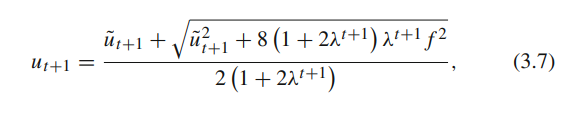

**add above equation on --->>   tnrd.py(modules)**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.spectral_norm import spectral_norm as SpectralNorm
from .modules.activations import *
import torchvision
from .modules.idct2_weight import gen_dct2
import numpy as np
import math

_NRBF=63
_DCT=False
_TIE = False
_BETA = False
_C1x1 = False
__all__ = ['g_tnrd','d_tnrd','TNRDlayer']

def initialize_weights(net, scale=1.):
    if not isinstance(net, list):
        net = [net]
    for layer in net:
        for m in layer.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, TNRDConv2d) or isinstance(m, TNRDlayer):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale  # for residual block
                if not _TIE and isinstance(m, TNRDlayer):
                    nn.init.kaiming_normal_(m.weight2, a=0, mode='fan_in')
                    m.weight.data *= scale  # for residual block
                if m.bias is not None and not isinstance(m, TNRDlayer):
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias.data, 0.0)


def init_model_param(model,num_reb_kernels=63,filter_size=5,stage=8,init_weight_dct=_DCT):
    w0 = np.load('w0_orig.npy')
    w0 = np.histogram(np.random.randn(1000)*0.02,num_reb_kernels-1)[1] if _NRBF != 63 else w0
    #
    means=np.linspace(-310,310,num_reb_kernels)
    precision=0.01
    NumW = num_reb_kernels
    step = 0.2
    delta = 10

    D = np.arange(-delta+means[0],means[-1]+delta,step)
    D_mu = D.reshape(1,-1).repeat(NumW,0) - means.reshape(-1,1).repeat(D.size,1)
    offsetD = D[1]
    nD = D.size
    G = np.exp(-0.5*precision*D_mu**2)
    filtN =  filter_size**2 - 1
    m = filter_size**2 - 1

    ww = np.array(w0).reshape(-1,1).repeat(filtN,1)
    cof_beta = np.eye(m,m)
    #x0 = zeros(length(cof_beta(:)) + 1 + filtN*mfs.NumW, stage);
    theta = [10, 5]+ np.ones(stage-2).tolist()
    pp = [math.log(1.0)]+ (math.log(0.1)*np.ones(stage-1)).tolist()
    # beta = [log(1) log(0.1)*ones(1,stage-1)];
    i=-1
    #import pdb; pdb.set_trace()
    for module in model.modules():
        if isinstance(module,TNRDlayer):
            i+=1
            init_layer_params(module,cof_beta, pp[i], ww*theta[i],init_weight_dct)

def init_layer_params(m,beta,p,wt,init_weight_dct):

    with torch.no_grad():
        if init_weight_dct:
            m.weight.copy_(torch.Tensor(beta))
        else:
            n = m.kernel_size**2 * m.in_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            if not _TIE and isinstance(m, TNRDlayer):
                weight_rot180 = torch.rot90(torch.rot90(m.weight.data.detach(), 1, [2, 3]),1,[2,3])
                m.weight2.data.copy_(weight_rot180)
                #m.weight2.data.normal_(0, math.sqrt(2. / n))
            #initialize_weights(m,0.02)
        m.alpha.copy_(torch.Tensor([p]))
        if m.act.weight.shape[-1]==24:
            m.act.weight.copy_(torch.Tensor(wt).unsqueeze(1))


class TNRDConv2d(nn.Conv2d):
    """docstring for TNRDConv2d."""

    def __init__(self, in_channels, out_channels, kernel_size=5,
                 stride=1, padding=2, dilation=1, groups=1, bias=True):
        super(TNRDConv2d, self).__init__(in_channels, out_channels, kernel_size,
                                      stride, padding, dilation, groups, bias)

        self.act = RBF(63,self.in_channels,triangular)
        self.alpha=nn.Parameter(torch.Tensor([0.9]))
        self.beta=nn.Parameter(torch.Tensor([1]))
        initialize_weights_dct([self], 0.02)
        self.pad_input=torchvision.transforms.Pad(5,padding_mode='edge')
        #initialize_weights([self.act], 0.00002)
        self.counter = 0
    def forward(self,input):
        self.counter+=1
        u,f=input
        up = self.pad_input(u)
        ur = up.repeat(1,self.in_channels,1,1)
        #
        output1 = F.conv2d(ur, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        output,_ = self.act(output1)
        weight_rot180 = torch.rot90(torch.rot90(self.weight, 1, [2, 3]),1,[2,3])
        #
        output = F.conv2d(output, weight_rot180, self.bias, self.stride, self.padding, self.dilation, self.groups)
        output = F.pad(output,(-5,-5,-5,-5))
        #import pdb; pdb.set_trace()
        if self.counter%100==0:
            print(self.alpha,self.beta.max(),self.beta.min(),self.act.weight.max(),self.act.weight.min(),output.sum(1,keepdim=True).max())
        output = u-self.beta*output.sum(1,keepdim=True)-self.alpha*(u-f)
       #u = u-output.mul(beta).sum(1,keepdim=True)-self.alpha.exp()*(u-f)
       #u = (u-output.mul(beta).sum(1,keepdim=True)+math.sqrt({u-(output.mul(beta).sum(1,keepdim=True))}**2 + 8(1+2*self.alpha.exp()) * self.alpha.exp() * (f)**2))/(2 * (1+2*self.alpha.exp()))

        return output,f

class TNRDlayer(nn.Module):
    """docstring for TNRDConv2d."""

    def __init__(self, in_channels, out_channels, kernel_size=5,
                 stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(TNRDlayer, self).__init__()
        self.in_channels = in_channels
        self.stride=stride
        self.groups=groups
        self.bias=bias
        self.padding=padding
        self.stride=stride
        self.dilation=dilation
        self.kernel_size=kernel_size
        self.act = RBF(_NRBF,self.in_channels,gaussian)
        self.alpha=nn.Parameter(torch.Tensor([0.9]))
        self.beta=nn.Parameter(torch.zeros([1,self.in_channels,1,1]))
        if _DCT:
            self.weight = nn.Parameter(torch.zeros([in_channels,in_channels]))
        else:
            self.weight = nn.Parameter(torch.zeros([in_channels,1,kernel_size,kernel_size]))
            if not _TIE:
                self.weight2 = nn.Parameter(torch.zeros([in_channels,1,kernel_size,kernel_size]))
        if _C1x1:
            self.weight_1x1=nn.Parameter(torch.zeros([in_channels,in_channels,1,1]))

        #initialize_weights_dct([self], 0.02)
        self.register_buffer('dct_filters',torch.tensor(gen_dct2(kernel_size)[1:,:]).float())

        self.pad_input=torchvision.transforms.Pad(12,padding_mode='symmetric')
        #initialize_weights([self.act], 0.00002)
        self.counter = 0

    def forward(self,input):
        self.counter+=1
        u,f=input

        for it in range(1):
            up = self.pad_input(u)
            ur = up.repeat(1,self.in_channels,1,1)
            #import pdb; pdb.set_trace()
            if _DCT:
                K=self.weight.matmul(self.dct_filters)
                K = K.div(torch.norm(K,dim=1,keepdim=True)+2.2e-16).view(self.kernel_size**2-1,1,self.kernel_size,self.kernel_size)
            else:
                K = self.weight

            output1 = F.conv2d(ur, K, None, self.stride, self.padding, self.dilation, self.groups)
            output,_ = self.act(output1)
            weight_rot180 = torch.rot90(torch.rot90(K, 1, [2, 3]),1,[2,3]) if _TIE else self.weight2
            if _C1x1:
                output = F.conv2d(output, self.weight_1x1, None, self.stride, self.padding, self.dilation)
            output = F.conv2d(output, weight_rot180, None, self.stride, self.padding, self.dilation, self.groups)
            output = F.pad(output,(-8,-8,-8,-8))
            #
            if self.counter%500==0:
                print(self.alpha,self.beta.max(),self.beta.min(),self.act.weight.max(),self.act.weight.min(),output.sum(1,keepdim=True).max())
            beta = self.beta if _BETA else 1
            #u = u-output.mul(beta).sum(1,keepdim=True)-self.alpha.exp()*(u-f)
            #u = (u-output.mul(beta).sum(1,keepdim=True)+math.sqrt((u-(output.mul(beta).sum(1,keepdim=True)))**2 + 8(1+2*self.alpha.exp()) * self.alpha.exp() * (f)**2))/(2 * (1+2*self.alpha.exp()))
            ##############MODIFIED_HERE____------------
            u = (u - output.mul(beta).sum(1, keepdim=True) + torch.sqrt((u - output.mul(beta).sum(1, keepdim=True))**2 + 8 * (1 + 2 * self.alpha.exp()) * self.alpha.exp() * (f)**2)) / (2 * (1 + 2 * self.alpha.exp()))
        return u,f
class GenBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, kernel_size=5, bias=True):
        super(GenBlock, self).__init__()
        self.conv = TNRDConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=(kernel_size // 2), bias=bias)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU(inplace=True)

        initialize_weights([self.conv, self.bn], 0.02)

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        return x

class DisBlock(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, bias=True, normalization=False):
        super(DisBlock, self).__init__()
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=bias)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_channels, affine=True)
        self.bn2 = nn.BatchNorm2d(out_channels, affine=True)

        initialize_weights([self.conv1, self.conv2], 0.1)

        if normalization:
            self.conv1 = SpectralNorm(self.conv1)
            self.conv2 = SpectralNorm(self.conv2)

    def forward(self, x):
        x = self.lrelu(self.bn1(self.conv1(x)))
        x = self.lrelu(self.bn2(self.conv2(x)))
        return x

class Generatorv1(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(Generatorv1, self).__init__()
        filter_size=5
        # image to features
        in_channels=filter_size**2

        #self.crop_output=torchvision.transforms.CenterCrop(50)
        self.image_to_features = TNRDConv2d(in_channels=in_channels, out_channels=in_channels,kernel_size=filter_size, groups=in_channels)
        # features
        blocks = []
        for _ in range(gen_blocks):
            blocks.append(TNRDConv2d(in_channels=in_channels, out_channels=in_channels,kernel_size=filter_size, bias=False,groups=in_channels))
        self.features = nn.Sequential(*blocks)

        # features to image
        self.features_to_image = TNRDConv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=filter_size,groups=in_channels)
        initialize_weights([self.features_to_image], 0.02)
        self.counter=0
    def forward(self, x):
        self.counter+=1
        x = self.image_to_features([x,x])
        x = self.features(x)
        x = self.features_to_image(x)
        return x[0]

class Generator(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(Generator, self).__init__()
        filter_size=5
        # image to features
        in_channels=(filter_size**2-1)

        #self.crop_output=torchvision.transforms.CenterCrop(50)
        self.image_to_features = TNRDlayer(in_channels=in_channels, out_channels=in_channels,groups=in_channels)
        # features
        blocks = []
        for _ in range(gen_blocks):
            blocks.append(TNRDlayer(in_channels=in_channels, out_channels=in_channels, bias=False,groups=in_channels))
        self.features = nn.Sequential(*blocks)

        #self.features = []
        #for _ in range(gen_blocks):
        #    self.features.append(TNRDlayer(in_channels=in_channels, out_channels=in_channels, bias=False,groups=in_channels))

        # features to image
        self.features_to_image = TNRDlayer(in_channels=in_channels, out_channels=in_channels, kernel_size=5,groups=in_channels)
        #initialize_weights([self.features_to_image], 0.02)
        self.counter=0
        init_model_param(self,num_reb_kernels=_NRBF,filter_size=5,stage=gen_blocks+2)

    def forward(self, x):

        self.counter+=1
        x = self.image_to_features([x,x])
        x = self.features(x)
        x = self.features_to_image(x)
        return x[0]

class Discriminator(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(Discriminator, self).__init__()

        # image to features
        self.image_to_features = DisBlock(in_channels=in_channels, out_channels=num_features, bias=True, normalization=False)

        # features
        blocks = []
        for i in range(0, dis_blocks - 1):
            blocks.append(DisBlock(in_channels=num_features * min(pow(2, i), 8), out_channels=num_features * min(pow(2, i + 1), 8), bias=False, normalization=False))
        self.features = nn.Sequential(*blocks)

        # classifier
        self.classifier = nn.Conv2d(in_channels=num_features * min(pow(2, dis_blocks - 1), 8), out_channels=1, kernel_size=4, padding=0)

    def forward(self, x):
        x = self.image_to_features(x)
        x = self.features(x)
        x = self.classifier(x)
        x = x.flatten(start_dim=1).mean(dim=-1)
        return x

class SNDiscriminator(nn.Module):
    def __init__(self, in_channels, num_features, gen_blocks, dis_blocks):
        super(SNDiscriminator, self).__init__()

        # image to features
        self.image_to_features = DisBlock(in_channels=in_channels, out_channels=num_features, bias=True, normalization=True)

        # features
        blocks = []
        for i in range(0, dis_blocks - 1):
            blocks.append(DisBlock(in_channels=num_features * min(pow(2, i), 8), out_channels=num_features * min(pow(2, i + 1), 8), bias=False, normalization=True))
        self.features = nn.Sequential(*blocks)

        # classifier
        self.classifier = SpectralNorm(nn.Conv2d(in_channels=num_features * min(pow(2, dis_blocks - 1), 8), out_channels=1, kernel_size=4, padding=0))

    def forward(self, x):
        x = self.image_to_features(x)
        x = self.features(x)
        x = self.classifier(x)
        x = x.flatten(start_dim=1).mean(dim=-1)
        return x

def g_tnrd(**config):
    config.setdefault('in_channels', 3)
    config.setdefault('num_features', 64)
    config.setdefault('gen_blocks', 3)
    config.setdefault('dis_blocks', 5)

    return Generator(**config)

def d_tnrd(**config):
    config.setdefault('in_channels', 3)
    config.setdefault('num_features', 64)
    config.setdefault('gen_blocks', 8)
    config.setdefault('dis_blocks', 5)

    return Discriminator(**config)

Epoch 2

Epoch 3

Epoch 4

Epoch 5

Epoch 6

Epoch 7

Epoch 8

Epoch 9

Epoch 10
Iteration 101, G: 1850.02942, G_recon: 1850.029415, tnrd_loss: 0.000086,
Evaluation: 16.957

Epoch 11

Epoch 12

Epoch 13

Epoch 14

Epoch 15

Epoch 16

Epoch 17

Epoch 18

Epoch 19
Iteration 201, G: 908.25291, G_recon: 908.252906, tnrd_loss: 0.000000,

Epoch 20
Evaluation: 22.181
Best PSNR Score: 22.18
█$ colab>>  